In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=2, IMG_HEIGHT= 512, IMG_WIDTH= 512, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs
    
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [2]:
#from CNN_model_segmentation import multi_unet_model #Uses softmax 
#from CNN_model_segmentation.py import*
from tensorflow.keras.utils import normalize
from tensorflow import keras
from tensorflow.keras import callbacks
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random

In [3]:
#Resizing images, if needed
SIZE_X = 500 
SIZE_Y = 500
n_classes=2 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("D:\\01_Thesis\\learning\\enpal\\val\\image_500\\New_folder"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif"))[0:800]:
        img = cv2.imread(img_path, 1)       
#         img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        img = np.pad(img,((6,6), (6,6), (0,0)),"constant",constant_values=(0))
        train_images.append(img)
       
## Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [4]:
# try_img = train_images[0]

# def pad_with(vector, pad_width, iaxis, kwargs):
#     pad_value = kwargs.get('padder', 10)
#     vector[:pad_width[0]] = pad_value
#     vector[-pad_width[1]:] = pad_value
    
# padded = np.pad(try_img,((103,103), (3,3), (0,0)),"constant",constant_values=(0))
# padded.shape

In [5]:
train_images.shape

(800, 512, 512, 3)

In [6]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("D:\\01_Thesis\\learning\\enpal\\val\\mask_500\\New_folder"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif"))[0:800]:
        mask = cv2.imread(mask_path, 0)       
#         mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        mask = np.pad(mask,((6,6), (6,6)),"constant",constant_values=(0))
        train_masks.append(mask)

print("uniques in train masks before", np.unique(train_masks))
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

# background class
# train_masks[train_masks < 20] = 0
# # train_masks[train_masks < 150 & train_masks > 50] = 1
# #Class 1 border
# mask = np.logical_and(train_masks < 80, train_masks > 19)
# train_masks[mask] = 1

# #Class 1 fill
# mask = np.logical_and(train_masks < 150, train_masks > 79)
# train_masks[mask] = 2

# #Class 1 border
# mask = np.logical_and(train_masks < 225, train_masks > 149)
# train_masks[mask] = 3

# #Class 2 fill
# train_masks[train_masks >= 225] = 4

uniques in train masks before [  0 255]


In [7]:
print(np.unique(train_masks))
train_masks.shape

[  0 255]


(800, 512, 512)

In [8]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
print(train_masks_reshaped.shape)
#x = labelencoder.fit(train_masks_reshaped)
#train_masks_reshaped_encoded = labelencoder.transform(x)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)

train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)


np.unique(train_masks_encoded_original_shape)

(209715200, 1)


C:\Users\bakthavatchalam\Anaconda3\envs\yolo\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1], dtype=int64)

In [9]:
#keys = labelencoder.classes_
#values = labelencoder.transform(keys)
#dic = dict(zip(keys,values))
#print(dic)

In [10]:
#################################################
train_images = np.expand_dims(train_images, axis=-1)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=-1)

In [11]:
print("train images shape = ",train_images.shape,"\n","train masks shape =", train_masks_input.shape )

train images shape =  (800, 512, 512, 3, 1) 
 train masks shape = (800, 512, 512, 1)


In [12]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

train_images = []
train_masks_input = []

train_masks = []
train_masks_reshaped = []
train_masks_reshaped_encoded = []
train_masks_encoded_original_shape = []

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)
X1 = []
y1 = []

In [13]:
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 



Class values in the dataset are ...  [0 1]


In [14]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [15]:
print("train masks cat =",train_masks_cat.shape )
print("y_train masks cat =",y_train_cat.shape )
print("test masks cat =",test_masks_cat.shape )
print("y_train masks cat =",y_test_cat.shape )



train_masks_cat = []
test_masks_cat = []

train masks cat = (576, 512, 512, 2)
y_train masks cat = (576, 512, 512, 2)
test masks cat = (80, 512, 512, 2)
y_train masks cat = (80, 512, 512, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


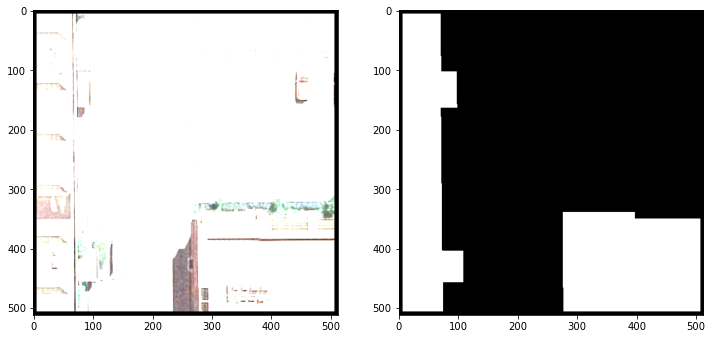

In [16]:
# Sanity check
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number]*50, (512, 512,3)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (512, 512))*125, cmap='gray')
plt.show()
#print(X_train[image_number])

In [17]:
###############################################################
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

TypeError: compute_class_weight() takes 1 positional argument but 3 were given

In [19]:

# from tensorflow.compat.v1 import ConfigProto
# import tensorflow as tf
# from tensorflow.compat.v1 import InteractiveSession
# # import tensorflow.keras.backend as K

IMG_HEIGHT = 512#X_train.shape[1]
IMG_WIDTH  = 512#X_train.shape[2]
IMG_CHANNELS = 3#X_train.shape[3]

# def fix_gpu():
#     config = ConfigProto()
#     config.gpu_options.allow_growth = True
#     session = InteractiveSession(config=config)
    
# fix_gpu()

# def binary_tversky_coef(y_true: tf.Tensor, y_pred: tf.Tensor, beta: float, smooth: float = 1.):
#     """
#     Tversky coefficient is a generalization of the Dice's coefficient. It adds an extra weight (β) to false positives
#     and false negatives:
#         TC(p, p̂) = p*p̂/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)]
#     When β=1/2, Tversky coefficient is equal to the Dice's coefficient:
#         TL(p, p̂) = p*p̂/[p*p̂ + (1/2)*(1-p)*p̂ + (1-(1/2))*p*(1-p̂)]
#         = p*p̂/[p*p̂ + (1/2)*p̂ - (1/2)*p*p̂ + (1/2)*p*(1-p̂)]
#         = p*p̂/[p*p̂ + (1/2)*p̂ - (1/2)*p*p̂ + (1/2)*p - (1/2)*p*p̂)]
#         = p*p̂/[p*p - p*p̂̂ + (1/2)*p̂ + (1/2)*p]
#         = p*p̂/[(1/2)*p̂ + (1/2)*p]
#         = p*p̂/[(1/2)*(p̂+p)]
#         = 2*p*p̂/(p̂+p)
#     :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
#     :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
#     :param beta: Weight coefficient (float)
#     :param smooth: Smoothing factor (float, default = 1.)
#     :return: Tversky coefficient (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>))
#     """
#     axis_to_reduce = range(1, K.ndim(y_pred))  # All axis but first (batch)
#     numerator = K.sum(y_true * y_pred, axis=axis_to_reduce)  # p*p̂
#     denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)  # p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)
#     denominator = K.sum(denominator, axis=axis_to_reduce)

#     return (numerator + smooth) / (denominator + smooth)  # (p*p̂ + smooth)/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂) + smooth]


# def binary_weighted_dice_crossentropy_loss(smooth: float = 1.,
#                                            beta: float = 0.5):
#     """
#     Weighted Dice cross entropy combination loss is a weighted combination between Dice's coefficient loss and
#     binary cross entropy:
#         DL(p, p̂) = 1 - (2*p*p̂+smooth)/(p+p̂+smooth)
#         CE(p, p̂) = - [p*log(p̂ + 1e-7) + (1-p)*log(1-p̂ + 1e-7)]
#         WDCE(p, p̂) = weight*DL + (1-weight)*CE
#                    = weight*[1 - (2*p*p̂+smooth)/(p+p̂+smooth)] - (1-weight)*[p*log(p̂ + 1e-7) + (1-p)*log(1-p̂ + 1e-7)]
#     Used as loss function for binary image segmentation with one-hot encoded masks.
#     :param smooth: Smoothing factor (float, default=1.)
#     :param beta: Loss weight coefficient (float, default=0.5)
#     :return: Dice cross entropy combination loss (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
#     """
#     assert 0. <= beta <= 1., "Loss weight has to be between 0.0 and 1.0"

#     def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
#         """
#         Compute the Dice cross entropy combination loss.
#         :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
#         :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
#         :return: Dice cross entropy combination loss (tf.Tensor, shape=(<BATCH_SIZE>,))
#         """
#         cross_entropy = K.binary_crossentropy(target=y_true, output=y_true)

#         # Average over each data point/image in batch
#         axis_to_reduce = range(1, K.ndim(cross_entropy))
#         cross_entropy = K.mean(x=cross_entropy, axis=axis_to_reduce)

#         dice_coefficient = binary_tversky_coef(y_true=y_true, y_pred=y_pred, beta=0.5, smooth=smooth)

#         return beta*(1. - dice_coefficient) + (1. - beta)*cross_entropy

#     return loss

# def balanced_cross_entropy(beta = 0.3):
#     def loss(y_true, y_pred):
#         weight_a = beta * tf.cast(y_true, tf.float32)
#         weight_b = (1 - beta) * tf.cast(1 - y_true, tf.float32)

#         o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b
#         return tf.reduce_mean(o)

#     return loss

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS) #balanced_cross_entropy(0.3)

model = get_model()###################################################'categorical_crossentropy'
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001), loss="categorical_crossentropy", 
              metrics=['accuracy',keras.metrics.MeanIoU(num_classes=n_classes)])
model.summary()

model_folder_name = "unet_weight_500" 

checkpoint_filepath = "D:\\01_Thesis\\learning\\enpal\\" + model_folder_name + "\\checkpoint"
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=True)


#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=400, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                     callbacks=[model_checkpoint_callback],
                    shuffle=False)
# model.save('unet_shapes_detect.hdf5')
                    
import pickle 
with open( model_folder_name +'with_border_trainstats', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
###########################################################
## Evaluate the model
## 	evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 512, 512, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

 spose)                         )                                                                 
                                                                                                  
 concatenate_6 (Concatenate)    (None, 256, 256, 64  0           ['conv2d_transpose_6[0][0]',     
                                )                                 'conv2d_22[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)             (None, 256, 256, 32  18464       ['concatenate_6[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_16 (Dropout)           (None, 256, 256, 32  0           ['conv2d_33[0][0]']              
                                )                                                                 
          

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# acc = history.history['mean_io_u']
val_acc = history.history['val_mean_io_u']

# plt.plot(epochs, acc, 'y', label='Training mean_iou')
# plt.plot(epochs, val_acc, 'r', label='Validation mean_iou')
# plt.title('Training and validation mean_iou')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
val_acc
max_value = max(val_acc)
max_index = val_acc.index(max_value)
print(max_index)

In [ ]:
model = keras.models.load_model("D:\\01_Thesis\\learning\\enpal\\" + model_folder_name + "\\checkpoint", compile=False)
model.summary()

In [ ]:
# Prediction
pred_img_name = "5.jpeg"
pred_path = r"D:\\01_Thesis\\unet\\vishnu\\test\\"
pred_path = pred_path + pred_img_name
act_img = cv2.imread(pred_path, 1) 
# img = np.pad(act_img,((103,103), (3,3), (0,0)),"constant",constant_values=(0))
pred_img = np.reshape(img,(1,256,256,3))
pred_img = np.expand_dims(pred_img, axis=-1)
pred_img = normalize(pred_img, axis=1)
pred_img = np.reshape(pred_img,(1,256,256,3))

pred = model.predict(pred_img)
out_img = np.zeros((256,256,3))
out_img[...,0:2] = np.reshape(pred,(256,256,2))
# class_1 = np.zeros((656,656,3))
# class_2 = np.zeros((656,656,3))
# class_1[:,:,0:2] = out_img[:,:,0:2].copy()
# class_1[:,:,2] = out_img[:,:,3].copy()

# class_2[:,:,0:2] = out_img[:,:,0:2].copy()
# class_2[:,:,2] = out_img[:,:,3].copy()
# class_1[:,:,0] = 0
# class_1[:,:,2] = 0
# class_2[:,:,0] = 0
# class_2[:,:,1] = 0
plt.imshow(class_1)
cv2.imwrite("D:\\01_Thesis\\unet\\vishnu\\test\\pred_" +pred_img_name,out_img)


In [ ]:
from matplotlib import colors, cm, pyplot as plt

img_no = 4
img = X_do_not_use[img_no]
img = np.reshape(img,(1,256,256,3))
print(img.shape)
# img = normalize(img)

pred = model.predict(img)

plt.figure(figsize=(12, 6))
plt.subplot(131)
#img = np.reshape(X_do_not_use[img_no], (656, 656,3))
img = np.squeeze(X_do_not_use[img_no]*50, axis=-1)
#norm = colors.LogNorm(img.mean() + 0.5 * img.std(), img.max(), clip='True')
plt.imshow(img, origin="lower")
pred = np.reshape(pred, (256, 256,2))
pred = pred[:,:,1] * 255
print(pred)
plt.imshow(np.reshape(X_do_not_use[img_no], (256, 256,3))*100)
plt.subplot(132)
plt.imshow(pred, cmap='gray')
plt.subplot(133)
plt.imshow(np.reshape(y_do_not_use[img_no], (256, 256)), cmap='gray')
plt.show()
#print(X_train[image_number])

In [ ]:
from matplotlib import colors, cm, pyplot as plt
import time
for img_no in range(X_do_not_use.shape[0]):

    img = X_do_not_use[img_no]
    img = np.reshape(img,(1,256,256,3))
    print(img.shape)
    # img = normalize(img)

    pred = model.predict(img)

    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    #img = np.reshape(X_do_not_use[img_no], (656, 656,3))
    img = np.squeeze(X_do_not_use[img_no]*50, axis=-1)
    #norm = colors.LogNorm(img.mean() + 0.5 * img.std(), img.max(), clip='True')
    plt.imshow(img, origin="lower")
    pred = np.reshape(pred, (256, 256,2))
    pred = pred[:,:,1]
    plt.imshow(np.reshape(X_do_not_use[img_no], (256, 256,3))*100)
    plt.subplot(132)
    plt.imshow(pred, cmap='gray')
    plt.subplot(133)
    plt.imshow(np.reshape(y_do_not_use[img_no], (256, 256)), cmap='gray')
    plt.show()
    time.sleep(1)
    #print(X_train[image_number])

In [ ]:
## Predict images in folder
from tqdm import tqdm
folder = r"D:\\01_Thesis\\learning\\enpal\\train\\image_250\\New_folder\\"
images = glob.glob(folder + "*.tif")
save_path = r"D:\\01_Thesis\\learning\\enpal\\train\\prediction\\"
# print(images)
for image in tqdm(images):
    file_name = image.split("\\")[-1]
    file_name = file_name.split(".")[0]
    print(file_name)
    img = cv2.imread(image, 1)
#     img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
    img = np.pad(img,((3,3), (3,3), (0,0)),"constant",constant_values=(0))
    img = np.reshape(img,(1,256,256,3))
    img = np.expand_dims(img, axis=-1)
    img = normalize(img, axis=1)
    img = np.reshape(img,(1,256,256,3))
    pred = model.predict(img)
    pred = np.reshape(pred, (256, 256,2))
    pred = pred[:,:,1]
#     pred = model.predict(img)
#     pred = np.reshape(pred, (256, 256,6))
#     temp = np.zeros((256,256,3))
# #     temp[:,:,0] = pred[:,:,0]
#     temp[:,:,0] = pred[:,:,0]
#     temp[:,:,1] = pred[:,:,1]
#     temp[:,:,1] = pred[:,:,2]
    save_img = save_path + file_name + "_Pred.tif"
    cv2.imwrite(save_img,pred*225)
    
    
    

    

In [ ]:
np.unique(pred).shape

In [ ]:
# save_path = "D:\\01_Thesis\\unet\\train\\masks\\model_51.jpeg"
# model_out = np.reshape(pred, (656, 656,3))
# cv2.imwrite(save_path,markers_8u[103:103+450,:]*125)

In [ ]:
# Prediction
pred_img_name = "23.jpeg"
pred_path = r"D:\\01_Thesis\\unet\\train\\images\\"
pred_path = pred_path + pred_img_name
act_img = cv2.imread(pred_path, 1) 
act_img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
# img = np.pad(act_img,((103,103), (3,3), (0,0)),"constant",constant_values=(0))
pred_img = np.reshape(img,(1,256,256,3))
pred_img = np.expand_dims(pred_img, axis=-1)
pred_img = normalize(pred_img, axis=1)
pred_img = np.reshape(pred_img,(1,256,256,3))

pred = model.predict(pred_img)
out_img = np.zeros((256,256,3))
out_img[...,0:2] = np.reshape(pred,(256,256,2))
# class_1 = np.zeros((656,656,0))
# class_2 = np.zeros((656,656,1))
# class_1[:,:,0:2] = out_img[:,:,0:2].copy()
# class_1[:,:,2] = out_img[:,:,3].copy()

# class_2[:,:,0:2] = out_img[:,:,0:2].copy()
# class_2[:,:,2] = out_img[:,:,3].copy()
# class_1[:,:,0] = 0
# class_1[:,:,2] = 0
# class_2[:,:,0] = 0
# class_2[:,:,1] = 0
plt.imshow(out_img)
# cv2.imwrite("D:\\01_Thesis\\unet\\train\\masks\\model_68.jpeg",class_1[103:103+450,:]*125)
cv2.imwrite("D:\\01_Thesis\\unet\\thesis_doc\\dist_model_1_21.jpeg",out_img)

In [ ]:
# info = np.iinfo(class_1.dtype) # Get the information of the incoming image type
# data = class_1.astype(np.float64) / info.max # normalize the data to 0 - 1
data = 255 * class_1 # Now scale by 255
# data = img
img = data.astype(np.uint8)


In [ ]:
# Create a kernel that we will use to sharpen our image
# an approximation of second derivative, a quite strong kernel
#class_1 = cv2.imread("D:\\01_Thesis\\unet\\train\\masks\\model_68.jpeg", 1)
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
# class_1 = class_1 * 125
# class_1 = class_1.astype('uint8')
imgLaplacian = cv2.filter2D(img, cv2.CV_32F, kernel)
sharp = np.float32(img)
imgResult = sharp - imgLaplacian
# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)
plt.imshow( imgLaplacian)
plt.imshow(imgResult)


In [ ]:
# Create binary image from source image
bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, bw = cv2.threshold(bw, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(bw)

In [ ]:
# Perform the distance transform algorithm
dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
plt.imshow( dist)
cv2.imwrite("D:\\01_Thesis\\unet\\thesis_doc\\dist_model_1_12.jpeg",dist[103:103+450,:]*125)

In [ ]:
# Threshold to obtain the peaks
# This will be the markers for the foreground objects
_, dist = cv2.threshold(dist, 0.4, 1.0, cv2.THRESH_BINARY)
# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv2.dilate(dist, kernel1)
plt.imshow( dist)

In [ ]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')
# Find total markers
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
cv2.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')
plt.imshow(markers_8u)
cont_det_image = cv2.cvtColor(markers_8u[103:103+450,:,], cv2.COLOR_GRAY2RGB)
cont_det_image[:,:,2] = cont_det_image[:,:,2] + 60
cont_det_image[:,:,1] = cont_det_image[:,:,1] + 120
cont_det_image[:,:,0] = cont_det_image[:,:,0] + 20
cv2.imwrite("D:\\01_Thesis\\unet\\thesis_doc\\contour_dect_model_1_23.jpeg",markers_8u[103:103+450,:,] + 25)

In [ ]:
# Perform the watershed algorithm
cv2.watershed(imgResult, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
#cv.imshow('Markers_v2', mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((random.randint(0,256), random.randint(0,256), random.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]
# Visualize the final image
plt.imshow( dst)
cv2.imwrite("D:\\01_Thesis\\unet\\thesis_doc\\wshed_model_2_23.jpeg",dst[103:103+450,:]*125)


In [ ]:
re_cont = []
temp = []
for cont in contours:
    for pts in cont:
        temp.append(pts[0])
    re_cont.append(temp)
    temp = []

In [ ]:
filt_cont = []

for cnt in re_cont:
    fg = 0
    for pts in cnt:
        if pts[1] > 500 or pts[1] < 180 :
            fg = 1
    if fg == 0:
        filt_cont.append(cnt)
        

In [ ]:
blank = np.zeros((656,656,3))
isClosed = True
  
# Blue color in BGR
color = (255, 255, 255)
  
# Line thickness of 2 px
thickness = 2
for cnt in filt_cont:
    blank = cv2.polylines(blank, [np.array(cnt)], 
                      isClosed, color, thickness)
    
plt.imshow(blank)

In [ ]:
# font
font = cv2.FONT_HERSHEY_SIMPLEX
  
# org
org = (50, 50)
  
# fontScale
fontScale = 1
   
# Blue color in BGR
color = (255, 255, 255)
  
# Line thickness of 2 px
thickness = 2
   
# # Using cv2.putText() method
# image = cv2.putText(blank, 'OpenCV', org, font, 
#                    fontScale, color, thickness, cv2.LINE_AA)

c = 1
for cnt in filt_cont:
    
    arr = np.array(cnt)
    x = np.max(arr[...,0])
    y = np.max(arr[...,1]) -103
    blank = cv2.putText(act_img, str(c), (x,y), font, 
                   fontScale, color, thickness, cv2.LINE_AA)
    c = c +1
    

In [ ]:
plt.imshow(cv2.cvtColor(blank, cv2.COLOR_BGR2RGB ))

In [ ]:
save_path = "D:\\01_Thesis\\unet\\thesis_doc\\inst_model_2_23.jpeg.jpeg"
# model_out = np.reshape(pred, (656, 656,3))
cv2.imwrite(save_path,blank)

# Border_filled based detection

# For loop images in folder

In [ ]:
## Predict images in folder
from tqdm import tqdm
folder = r"C:\Users\bakthavatchalam\Desktop\unet\border_filled_data\train\\"
images = glob.glob(folder + "*.jpeg")
save_path = r"C:\Users\bakthavatchalam\Desktop\unet\predicted\\"
# print(images)
classes = [1,2]
for image in tqdm(images):
    file_name = image.split("\\")[-1]
    read_img = cv2.imread(image, 1)
    act_img = read_img.copy()
    read_img = np.pad(read_img,((103,103), (3,3), (0,0)),"constant",constant_values=(0))
    read_img = np.reshape(read_img,(1,656,656,3))
    read_img = np.expand_dims(read_img, axis=-1)
    read_img = normalize(read_img, axis=1)
    read_img = np.reshape(read_img,(1,656,656,3))
    pred = model.predict(read_img)
    pred = np.reshape(pred, (656, 656,5))

    
    for cls in classes:
        
        temp_cls = np.zeros((656,656,3))
        if cls == 1:
            temp_cls[:,:,1] = pred[:,:,1]
        
        if cls == 2:
            temp_cls[:,:,2] = pred[:,:,3]
        data = 255 * temp_cls
        
        img = data.astype(np.uint8)
        kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
        imgLaplacian = cv2.filter2D(img, cv2.CV_32F, kernel)
        sharp = np.float32(img)
        imgResult = sharp - imgLaplacian
        imgResult = np.clip(imgResult, 0, 255)
        imgResult = imgResult.astype('uint8')
        imgLaplacian = np.clip(imgLaplacian, 0, 255)
        imgLaplacian = np.uint8(imgLaplacian)
        bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, bw = cv2.threshold(bw, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
        cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
        _, dist = cv2.threshold(dist, 0.4, 1.0, cv2.THRESH_BINARY)
        kernel1 = np.ones((3,3), dtype=np.uint8)
        dist = cv2.dilate(dist, kernel1)
        dist_8u = dist.astype('uint8')
        # Find total markers
        contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Create the marker image for the watershed algorithm
        markers = np.zeros(dist.shape, dtype=np.int32)
        # Draw the foreground markers
        for i in range(len(contours)):
            cv2.drawContours(markers, contours, i, (i+1), -1)
        # Draw the background marker
        cv2.circle(markers, (5,5), 3, (255,255,255), -1)
        markers_8u = (markers * 10).astype('uint8')
        cv2.watershed(imgResult, markers)
        #mark = np.zeros(markers.shape, dtype=np.uint8)
        mark = markers.astype('uint8')
        mark = cv2.bitwise_not(mark)
        # uncomment this if you want to see how the mark
        # image looks like at that point
        #cv.imshow('Markers_v2', mark)
        # Generate random colors
        colors = []
        for contour in contours:
            colors.append((random.randint(0,256), random.randint(0,256), random.randint(0,256)))
        # Create the result image
        dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
        # Fill labeled objects with random colors
        for i in range(markers.shape[0]):
            for j in range(markers.shape[1]):
                index = markers[i,j]
                if index > 0 and index <= len(contours):
                    dst[i,j,:] = colors[index-1]
                    
        re_cont = []
        temp = []
        for cont in contours:
            for pts in cont:
                temp.append(pts[0])
            re_cont.append(temp)
            temp = []
            
        filt_cont = []

        for cnt in re_cont:
            fg = 0
            for pts in cnt:
                if pts[1] > 500 or pts[1] < 180 :
                    fg = 1
            if fg == 0:
                filt_cont.append(cnt)
                
        blank = np.zeros((656,656,3))
        isClosed = True

        # Blue color in BGR
        color = (255, 255, 255)

        # Line thickness of 2 px
        thickness = 2
        for cnt in filt_cont:
            blank = cv2.polylines(blank, [np.array(cnt)], 
                              isClosed, color, thickness)
            
        font = cv2.FONT_HERSHEY_SIMPLEX
  

        org = (50, 50)

        # fontScale
        fontScale = 1

        # Blue color in BGR
        if cls == 1:
            color = (255, 255, 255)
            
        if cls == 2:
            color = (0, 0, 0)

        # Line thickness of 2 px
        thickness = 2

        # # Using cv2.putText() method
        # image = cv2.putText(blank, 'OpenCV', org, font, 
        #                    fontScale, color, thickness, cv2.LINE_AA)

        c = 1
        for cnt in filt_cont:

            arr = np.array(cnt)
            x = np.max(arr[...,0])
            y = np.max(arr[...,1]) -103
            blank = cv2.putText(act_img, str(c), (x,y), font, 
                           fontScale, color, thickness, cv2.LINE_AA)
            c = c +1
    

        cv2.imwrite("C:\\Users\\bakthavatchalam\\Desktop\\unet\\pred_numbered\\" + file_name,blank)
    

# Centre or picking place determination

In [ ]:
## Predict images in folder
from tqdm import tqdm
folder = r"C:\Users\bakthavatchalam\Desktop\unet\border_filled_data\train\\"
images = glob.glob(folder + "*.jpeg")
# images = [images[0]]
print(images)
save_path = r"C:\Users\bakthavatchalam\Desktop\unet\predicted\\"
# print(images)
classes = [1,2]
for image in tqdm(images):
    file_name = image.split("\\")[-1]
    print(file_name)
    read_img = cv2.imread(image, 1)
    act_img = read_img.copy()
    read_img = np.pad(read_img,((103,103), (3,3), (0,0)),"constant",constant_values=(0))
    read_img = np.reshape(read_img,(1,656,656,3))
    read_img = np.expand_dims(read_img, axis=-1)
    read_img = normalize(read_img, axis=1)
    read_img = np.reshape(read_img,(1,656,656,3))
    pred = model.predict(read_img)
    pred = np.reshape(pred, (656, 656,5))
    centres_1 = []
    centres_2 = []

    
    for cls in classes:
        
        temp_cls = np.zeros((656,656,3))
        if cls == 1:
            temp_cls[:,:,1] = pred[:,:,1]
        
        if cls == 2:
            temp_cls[:,:,2] = pred[:,:,3]
        data = 255 * temp_cls
        
        img = data.astype(np.uint8)
        kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
        imgLaplacian = cv2.filter2D(img, cv2.CV_32F, kernel)
        sharp = np.float32(img)
        imgResult = sharp - imgLaplacian
        imgResult = np.clip(imgResult, 0, 255)
        imgResult = imgResult.astype('uint8')
        imgLaplacian = np.clip(imgLaplacian, 0, 255)
        imgLaplacian = np.uint8(imgLaplacian)
        bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, bw = cv2.threshold(bw, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
        cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
        _, dist = cv2.threshold(dist, 0.4, 1.0, cv2.THRESH_BINARY)
        kernel1 = np.ones((3,3), dtype=np.uint8)
        dist = cv2.dilate(dist, kernel1)
        dist_8u = dist.astype('uint8')
        # Find total markers
        contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Create the marker image for the watershed algorithm
        markers = np.zeros(dist.shape, dtype=np.int32)
        # Draw the foreground markers
        for i in range(len(contours)):
            cv2.drawContours(markers, contours, i, (i+1), -1)
        # Draw the background marker
        cv2.circle(markers, (5,5), 3, (255,255,255), -1)
        markers_8u = (markers * 10).astype('uint8')
        cv2.watershed(imgResult, markers)
        #mark = np.zeros(markers.shape, dtype=np.uint8)
        mark = markers.astype('uint8')
        mark = cv2.bitwise_not(mark)
        # uncomment this if you want to see how the mark
        # image looks like at that point
        #cv.imshow('Markers_v2', mark)
        # Generate random colors
        colors = []
        for contour in contours:
            colors.append((random.randint(0,256), random.randint(0,256), random.randint(0,256)))
        # Create the result image
        dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
        # Fill labeled objects with random colors
        for i in range(markers.shape[0]):
            for j in range(markers.shape[1]):
                index = markers[i,j]
                if index > 0 and index <= len(contours):
                    dst[i,j,:] = colors[index-1]
                    
       # extracting contours infomation             
        re_cont = []
        temp = []
        for cont in contours:
            for pts in cont:
                temp.append(pts[0])
            re_cont.append(temp)
            temp = []
            
        filt_cont = re_cont#[]

#         for cnt in re_cont:
#             fg = 0
#             for pts in cnt:
#                 if pts[1] > 500 or pts[1] < 180 :
#                     fg = 1
#             if fg == 0:
#                 filt_cont.append(cnt)
                
        blank = np.zeros((656,656,3))
        isClosed = True

        # Blue color in BGR
        color = (255, 255, 255)

        # Line thickness of 2 px
        thickness = 2
        for cnt in filt_cont:
            blank = cv2.polylines(blank, [np.array(cnt)], 
                              isClosed, color, thickness)
            
        font = cv2.FONT_HERSHEY_SIMPLEX
  

        org = (50, 50)

        # fontScale
        fontScale = 1

        # Blue color in BGR
        if cls == 1:
            color = (255, 255, 255)
            
        if cls == 2:
            color = (0, 0, 0)

        # Line thickness of 2 px
        thickness = 2

        # # Using cv2.putText() method
        # image = cv2.putText(blank, 'OpenCV', org, font, 
        #                    fontScale, color, thickness, cv2.LINE_AA)
        

        
        for cnt in filt_cont:
            arr = np.array(cnt)
            M = cv2.moments(arr)
            if M['m00'] != 0:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00']) -103
                cv2.putText(act_img, "X", (cx, cy), font, 0.5, (0, 0, 0), 2)
                
            if cls == 1:
                centres_1.append((cx,cy))
            if cls == 2:
                centres_2.append((cx,cy))


        c = 1
        for cnt in filt_cont:

            arr = np.array(cnt)
            x = np.max(arr[...,0])
            y = np.max(arr[...,1]) -103
            blank = cv2.putText(act_img, str(c), (x,y), font, 
                           fontScale, color, thickness, cv2.LINE_AA)
            c = c + 1
        

        cv2.imwrite("C:\\Users\\bakthavatchalam\\Desktop\\unet\\pred_numbered\\" + file_name, blank)
    


In [ ]:
centres_1

In [ ]:
centres_2